import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [1]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
import os 
import pandas as pd
import plotly.graph_objs as go
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
train = pd.read_csv('../input/plant-pathology-2020-fgvc7/train.csv')
train['image_id'] = train['image_id']+'.jpg'
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0.jpg,0,0,0,1
1,Train_1.jpg,0,1,0,0
2,Train_2.jpg,1,0,0,0
3,Train_3.jpg,0,0,1,0
4,Train_4.jpg,1,0,0,0


In [5]:
img=[]
filename=train.image_id
for file in filename:
    image=cv2.imread("../input/plant-pathology-2020-fgvc7/images/"+file)
    res=cv2.resize(image,(256,256))
    img.append(res)
img=np.array(img)

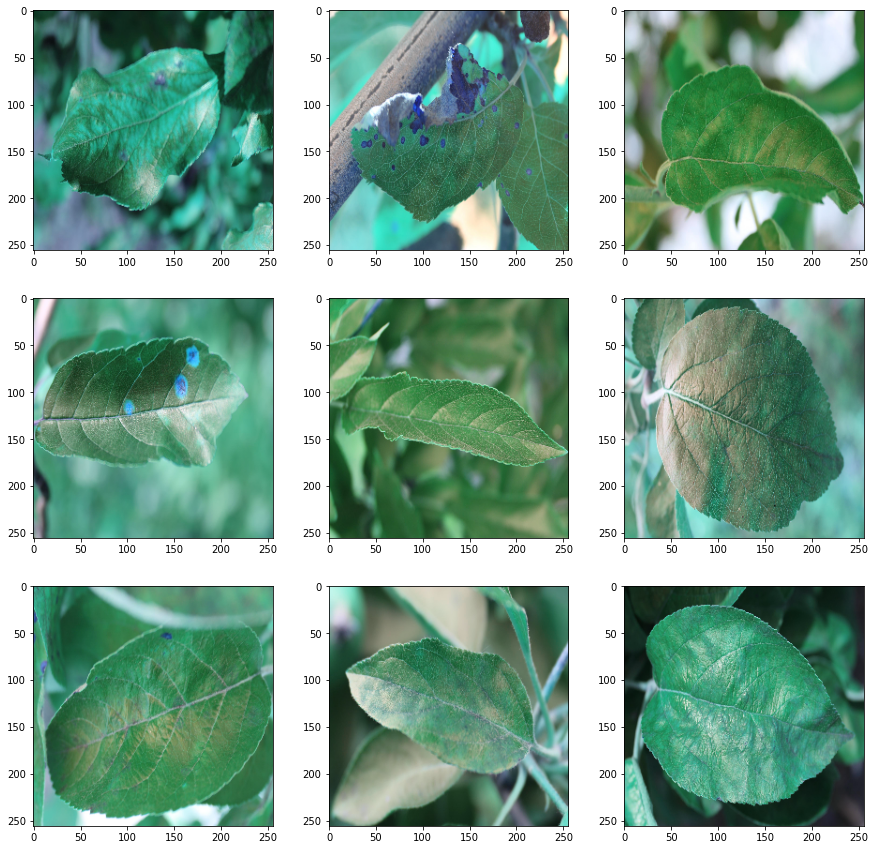

In [6]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(img[i])

In [7]:
train_labels = np.float32(train.loc[:, 'healthy':'scab'].values)

In [8]:
train_labels

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [9]:
train, val = train_test_split(train, test_size = 0.15)

In [10]:

from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    fill_mode='nearest',
    shear_range=0.1,
    rescale=1/255,
    brightness_range=[0.5, 1.5])

In [12]:
train_generator = train_datagen.flow_from_dataframe(
                train, directory = '../input/plant-pathology-2020-fgvc7/images',
                target_size = (128,128),
                x_col = 'image_id',
                y_col = ['healthy','multiple_diseases','rust','scab'],
                class_mode='raw',
                shuffle=False,
                subset='training',
                batch_size = 16
)

Found 1547 validated image filenames.


In [14]:
val_generator=train_datagen.flow_from_dataframe(val,directory='../input/plant-pathology-2020-fgvc7/images',
                                                      target_size=(128,128),
                                                      x_col="image_id",
                                                      y_col=['healthy','multiple_diseases','rust','scab'],
                                                      class_mode='raw',
                                                      shuffle=False,
                                                      batch_size=16,
                                                  )

Found 274 validated image filenames.


In [15]:
from keras.applications.densenet import DenseNet121
from keras.models import Model
import keras
from keras import optimizers
import tensorflow as tf

In [16]:
pretrained_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(128,128,3))

29089792/29084464 [==============================] - 0s 0us/step


In [24]:
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax')  
    ])

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss= tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc'] 

)

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 4, 4, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________


In [27]:
from keras.callbacks import ReduceLROnPlateau

In [28]:
history_1 = model.fit_generator(train_generator,steps_per_epoch=20,
                               epochs=100, validation_data=val_generator,
                               validation_steps=100,
                               verbose = 1, callbacks=[ReduceLROnPlateau(monitor= 'loss', factor=0.3, patience=3, min_lr=0.000001)],
                                use_multiprocessing=False,
                               shuffle=True
                               )

Epoch 1/100
20/20 [==============================] - 35s 1s/step - loss: 0.8025 - acc: 0.7088 - val_loss: 261.7969 - val_acc: 0.3394
Epoch 2/100
20/20 [==============================] - 12s 621ms/step - loss: 0.8108 - acc: 0.7619
Epoch 3/100
20/20 [==============================] - 12s 588ms/step - loss: 0.4668 - acc: 0.8446
Epoch 4/100
20/20 [==============================] - 12s 612ms/step - loss: 0.5067 - acc: 0.8510
Epoch 5/100
20/20 [==============================] - 12s 582ms/step - loss: 0.6486 - acc: 0.7779
Epoch 6/100
20/20 [==============================] - 12s 584ms/step - loss: 0.4941 - acc: 0.8212
Epoch 7/100
20/20 [==============================] - 13s 636ms/step - loss: 0.6516 - acc: 0.7969
Epoch 8/100
20/20 [==============================] - 12s 600ms/step - loss: 0.3406 - acc: 0.9068
Epoch 9/100
20/20 [==============================] - 12s 619ms/step - loss: 0.6388 - acc: 0.8259
Epoch 10/100
20/20 [==============================] - 14s 678ms/step - loss: 0.3514 - acc: 

In [37]:
model.save("modelv2_1.h5")

In [39]:
from keras.models import load_model
m= load_model('modelv2_1.h5')
m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 4, 4, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________
